In [1]:
import datetime as dt
import logging
import json
from pathlib import Path

from pyspark.sql import SparkSession
import pandas as pd

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

data_dir = Path("/projects/dsgrid/tempo-project/april-queries/")
dataset_name = "full_dataset"

spark = (
            SparkSession.builder
            .appName("dsgrid")
            .config("spark.sql.sources.partitionColumnTypeInference.enabled", "false")
            .config("spark.sql.session.timeZone", "EST")
            .getOrCreate()
        )
settings = spark.sparkContext.getConf().getAll()
for item in ["spark.sql.sources.partitionColumnTypeInference.enabled", "spark.sql.session.timeZone"]:
    if item not in [x[0] for x in settings]:
        settings.append((item, spark.conf.get(item)))
settings

24/05/08 15:23:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


[('spark.master', 'spark://x1007c0s0b0n0:7077'),
 ('spark.driver.host', 'x1007c0s0b0n0.hsn.cm.kestrel.hpc.nrel.gov'),
 ('spark.sql.shuffle.partitions', '103'),
 ('spark.executor.cores', '5'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.maxResultSize', '1g'),
 ('spark.driver.memory', '1g'),
 ('spark.app.startTime', '1715203415324'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.executor.memory', '12g'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED

## Partitioned File Utilities

In [2]:
def is_partitioned(filepath):
    for p in filepath.iterdir():
        if p.is_dir() and ("=" in p.stem) and (len(p.stem.split("=")) == 2):
            return True
    return False

def get_partitions(filepath):
    assert is_partitioned(filepath), f"{filepath} is not partitioned"
    
    partition_name = None
    for p in filepath.iterdir():
        if p.is_dir() and ("=" in p.stem):
            tmp, value = p.stem.split("=")
            if partition_name:
                assert (tmp == partition_name), f"Found two different partition names in {filepath}: {partition_name}, {tmp}"
            partition_name = tmp
            yield partition_name, value, p

def print_partitions(filepath, print_depth=2, _depth=0):
    if is_partitioned(filepath):
        space = ' ' * 4 * _depth
        for partition_name, value, p in get_partitions(filepath):
            print(f"{space}{partition_name}={value}")
        if (not print_depth) or ((_depth + 1) < print_depth):
            print_partitions(p, print_depth=print_depth, _depth=_depth+1)

## Load Data

In [3]:
def get_metadata(dataset_path):
    with open(dataset_path / "metadata.json") as f:
        result = json.load(f)
    return result

# load metadata and get column names by type
metadata = get_metadata(data_dir / dataset_name)
assert metadata["table_format"]["format_type"] == "unpivoted", metadata["table_format"]
value_column = metadata["table_format"]["value_column"]
columns_by_type = {dim_type: metadata["dimensions"][dim_type][0]["column_names"][0] 
                   for dim_type in metadata["dimensions"] if metadata["dimensions"][dim_type]}

In [4]:
# Load data table
filepath = data_dir / dataset_name / "table.parquet"
df = spark.read.parquet(str(filepath))
tablename = "tbl"
df.createOrReplaceTempView(tablename)
logger.info(f"Loaded {filepath} as {tablename}:\n{df.printSchema()}")
df.show(n=5)

INFO:__main__:Loaded /projects/dsgrid/tempo-project/april-queries/full_dataset/table.parquet as tbl:
None


root
 |-- time_est: timestamp (nullable = true)
 |-- end_use: string (nullable = true)
 |-- household_and_vehicle_type: string (nullable = true)
 |-- transportation: string (nullable = true)
 |-- weather_2012: string (nullable = true)
 |-- value: double (nullable = true)
 |-- county: integer (nullable = true)
 |-- scenario: string (nullable = true)
 |-- tempo_project_model_years: string (nullable = true)
 |-- state: string (nullable = true)



+-------------------+-------------------+--------------------------+--------------+------------+-----+------+---------+-------------------------+-----+
|           time_est|            end_use|household_and_vehicle_type|transportation|weather_2012|value|county| scenario|tempo_project_model_years|state|
+-------------------+-------------------+--------------------------+--------------+------------+-----+------+---------+-------------------------+-----+
|2012-01-24 06:00:00|electricity_ev_l1l2|      Some_Drivers_Smal...|         trans|        2012|  0.0| 13145|reference|                     2038|   GA|
|2012-05-16 03:00:00|electricity_ev_dcfc|      Some_Drivers_Smal...|         trans|        2012|  0.0| 13297|reference|                     2038|   GA|
|2012-01-24 06:00:00|electricity_ev_dcfc|      Some_Drivers_Smal...|         trans|        2012|  0.0| 13145|reference|                     2038|   GA|
|2012-05-09 03:00:00|electricity_ev_l1l2|      Some_Drivers_Smal...|         trans|     

In [5]:
print(f"Dataset contains {df.count():,} data points")

Dataset contains 264,288,771,856 data points


## Recreate Lefthand Side of Figure ES-1

Note that even on a large, high performance compute node, this query results in an OutOfMemoryError when run on `dataset_name = "state_level_simplified"` in local mode.

In [81]:
df = spark.sql(f"""SELECT scenario, {columns_by_type["model_year"]} as year, SUM({value_column})/1.0E6 as annual_twh
                     FROM {tablename} 
                 GROUP BY scenario, {columns_by_type["model_year"]}
                 ORDER BY scenario, year""").toPandas()
df["scenario"] = df["scenario"].map({
    "efs_high_ldv": "EFS High Electrification",
    "ldv_sales_evs_2035": "All LDV Sales EV by 2035",
    "reference": "AEO Reference"
})

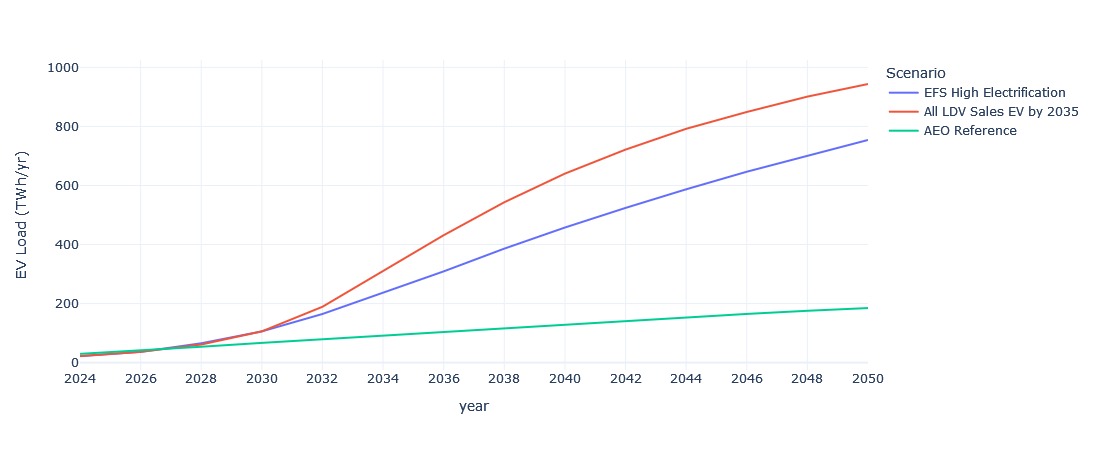

In [82]:
import plotly.express as px

fig = px.line(df, x="year", y="annual_twh", color="scenario", 
              labels={"annual_twh": "EV Load (TWh/yr)", "scenario": "Scenario"}, 
              range_y=[-25,1025],
              width=600, height=450, template="plotly_white")
fig

## Verify Timestamps Are As Expected

Timestamps show up as expected because of setting the spark.sql.session.timeZone configuration to "EST" (in the first cell).

In [67]:
assert columns_by_type["time"] == "time_est", "Code in this section only makes sense if the dataset has timestamps"

In [68]:
# select a subset of the data and look at initial timestamps

where_clause = f"(scenario = 'reference') AND ({columns_by_type['model_year']} = 2050)"

if columns_by_type['geography'] == "census_division":
    where_clause += f" AND ({columns_by_type['geography']} = 'middle_atlantic')"
elif columns_by_type['geography'] == "state":
    where_clause += f" AND ({columns_by_type['geography']} = 'RI')"
elif columns_by_type['geography'] == "county":
    where_clause += f" AND ({columns_by_type['geography']} = '39023')"
else:
    raise NotImplementedError()

if "subsector" not in columns_by_type:
    pass
elif columns_by_type['subsector'] == "subsector":
    where_clause += f" AND ({columns_by_type['subsector']} = 'bev_compact')"
elif columns_by_type['subsector'] == "household_and_vehicle_type":
    where_clause += f" AND ({columns_by_type['subsector']} = 'Some_Drivers_Larger+Low_Income+Second_City+Pickup+BEV_100')"
else:
    raise NotImplementedError()

if columns_by_type['metric'] == "end_uses_by_fuel_type":
    pass
elif columns_by_type['metric'] == "end_use":
    where_clause += f" AND ({columns_by_type['metric']} = 'electricity_ev_l1l2')"   
else:
    raise NotImplementedError()

df = spark.sql(f"SELECT * FROM {tablename} WHERE {where_clause} ORDER BY time_est LIMIT 5;")
df.show()

+-----+-------------------+-------------------------+---------+--------------------------+-------------------+-----+
|state|            end_use|tempo_project_model_years| scenario|household_and_vehicle_type|           time_est|value|
+-----+-------------------+-------------------------+---------+--------------------------+-------------------+-----+
|   RI|electricity_ev_l1l2|                     2050|reference|      Some_Drivers_Larg...|2012-01-01 00:00:00|  0.0|
|   RI|electricity_ev_l1l2|                     2050|reference|      Some_Drivers_Larg...|2012-01-01 01:00:00|  0.0|
|   RI|electricity_ev_l1l2|                     2050|reference|      Some_Drivers_Larg...|2012-01-01 02:00:00|  0.0|
|   RI|electricity_ev_l1l2|                     2050|reference|      Some_Drivers_Larg...|2012-01-01 03:00:00|  0.0|
|   RI|electricity_ev_l1l2|                     2050|reference|      Some_Drivers_Larg...|2012-01-01 04:00:00|  0.0|
+-----+-------------------+-------------------------+---------+-

## Verify that Profiles in Different Timezones Are As Expected

In [6]:
assert columns_by_type["time"] == "time_est", "Code in this section only makes sense if the dataset has timestamps"

In [10]:
def get_profile(start_timestamp, end_timestamp, where_clause, 
                tablename=tablename, value_column=value_column, 
                normalize_profile=True, replace_timestamps=True):
    df = spark.sql(f"""SELECT time_est, SUM({value_column}) as {value_column}
                         FROM {tablename} 
                        WHERE {where_clause} AND (time_est >= TIMESTAMP '{start_timestamp}') AND (time_est <= TIMESTAMP '{end_timestamp}')
                     GROUP BY time_est 
                     ORDER BY time_est;""").toPandas()
    if normalize_profile:
        df[value_column] = df[value_column] / df[value_column].sum()
    if replace_timestamps:
        df["hour"] = df.index.values
        df = df[["hour",value_column]]
    return df

where_clause = f"(scenario = 'reference') AND ({columns_by_type['model_year']} = 2050)"

if "subsector" not in columns_by_type:
    pass
elif columns_by_type['subsector'] == "subsector":
    where_clause += f" AND ({columns_by_type['subsector']} = 'bev_compact')"
elif columns_by_type['subsector'] == "household_and_vehicle_type":
    where_clause += f" AND ({columns_by_type['subsector']} = 'Some_Drivers_Smaller+Middle_Income+Suburban+SUV+BEV_300')"
else:
    raise NotImplementedError()

geographies = None
if columns_by_type['geography'] == "census_division":
    geographies = {"ET": "middle_atlantic", "CT": "west_south_central", "MT": "mountain", "PT": "pacific"}
elif columns_by_type['geography'] == "state":
    geographies = {"ET": "NC", "CT": "TX", "MT": "CO", "PT": "OR"}
elif columns_by_type['geography'] == "county":
    geographies = {"ET": "37183", "CT": "48453", "MT": "08069", "PT": "06059"}
else:
    raise NotImplementedError()

days = {
    "Standard Time": (dt.datetime(2012, 2, 14, 0), dt.datetime(2012, 2, 14, 23)),
    "Daylight Savings Time": (dt.datetime(2012, 8, 14, 0), dt.datetime(2012, 8, 14, 23))
}

data = []
for time_type, time_tuple in days.items():
    for tz, geo in geographies.items():
        data.append(get_profile(time_tuple[0], time_tuple[1], where_clause + f" AND {columns_by_type['geography']} = '{geo}'"))
        data[-1]["Time Type"] = time_type
        data[-1]["Time Zone"] = tz
df = pd.concat(data)
df

,hour,value,Time Type,Time Zone
0,0,0.0,Standard Time,ET
1,1,0.0,Standard Time,ET
2,2,0.0,Standard Time,ET
3,3,0.0,Standard Time,ET
4,4,0.0,Standard Time,ET
...,...,...,...,...
19,19,0.0,Daylight Savings Time,PT
20,20,0.0,Daylight Savings Time,PT
21,21,0.0,Daylight Savings Time,PT
22,22,0.0,Daylight Savings Time,PT


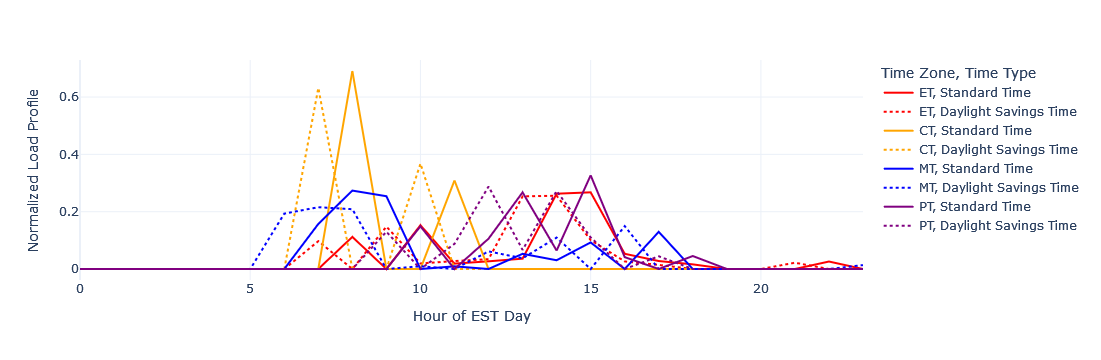

In [11]:
import plotly.express as px

fig = px.line(df, x="hour", y=value_column, color="Time Zone", line_dash="Time Type",
              color_discrete_map={"ET": "red", "CT": "orange", "MT": "blue", "PT": "purple"},
              labels={"value": "Normalized Load Profile", "hour": "Hour of EST Day"},
              #range_y=[0,0.1],
              width=600, template="plotly_white")
fig

## Demonstrate Loading a Subset of a Larger Dataset

In [15]:
filepath = data_dir / dataset_name / "table.parquet"
print_partitions(filepath, print_depth=2)

scenario=efs_high_ldv
scenario=ldv_sales_evs_2035
scenario=reference
    tempo_project_model_years=2024
    tempo_project_model_years=2046
    tempo_project_model_years=2030
    tempo_project_model_years=2044
    tempo_project_model_years=2026
    tempo_project_model_years=2036
    tempo_project_model_years=2042
    tempo_project_model_years=2050
    tempo_project_model_years=2028
    tempo_project_model_years=2048
    tempo_project_model_years=2040
    tempo_project_model_years=2038
    tempo_project_model_years=2032
    tempo_project_model_years=2034


In [17]:
# Edit this list of tuples as desired
partitions=[
    ("scenario", "ldv_sales_evs_2035"),
    ("tempo_project_model_years", "2040")
]

subset_filepath = filepath
for partition_name, value in partitions:
    subset_filepath = subset_filepath / f"{partition_name}={value}"

# Load partial data table
df = spark.read.parquet(str(subset_filepath))
tablename = "tbl"
df.createOrReplaceTempView(tablename)
df.show(n=5)

+-------------------+-------------------+--------------------------+--------------+------------+-------------------+------+-----+
|           time_est|            end_use|household_and_vehicle_type|transportation|weather_2012|              value|county|state|
+-------------------+-------------------+--------------------------+--------------+------------+-------------------+------+-----+
|2012-11-23 05:00:00|electricity_ev_l1l2|      Single_Driver+Mid...|         trans|        2012|                0.0| 39051|   OH|
|2012-04-11 15:00:00|electricity_ev_l1l2|      Single_Driver+Low...|         trans|        2012|0.30578384399414066| 39101|   OH|
|2012-11-23 05:00:00|electricity_ev_dcfc|      Single_Driver+Mid...|         trans|        2012|                0.0| 39051|   OH|
|2012-04-11 15:00:00|electricity_ev_dcfc|      Single_Driver+Low...|         trans|        2012|                0.0| 39101|   OH|
|2012-11-09 05:00:00|electricity_ev_l1l2|      Single_Driver+Mid...|         trans|       

In [18]:
print(f"Partial dataset contains {df.count():,} data points")

Partial dataset contains 11,120,932,266 data points
